# Getting started

### Initialize streams

[Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects define material flow rates along with its thermodynamic state. Before creating streams, a [Thermo](https://thermosteam.readthedocs.io/en/latest/Thermo.html) property package must be defined. Alternatively, we can just pass chemical names and BioSTEAM will automatically create a property package based on ideal mixing rules and UNIFAC activity coefficients for thermodynamic equilibrium. More complex packages can be defined through Thermosteam, BioSTEAM's premier thermodynamic engine. Please visit [Thermosteam's documentation](https://thermosteam.readthedocs.io/en/latest/index.html) for a complete tutorial on [Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects and how to create a property package. In this example, a simple feed stream with a few common chemicals will be initialized:

In [1]:
import biosteam as bst
bst.settings.set_thermo(['Water', 'Methanol'])
feed = bst.Stream(Water=50, Methanol=20)
feed.show()

Stream: s1
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (kmol/hr): Water     50
                 Methanol  20


Set prices for performing techno-economic analysis later:

In [2]:
feed.price = 0.15 # USD/kg
feed.cost # USD/hr

231.24018

### Process settings

Process settings include price of feeds and products, conditions of utilities, and the chemical engineering plant cost index. These should be set before simulating a system.

Set the chemical engineering plant cost index:

In [3]:
bst.CE # Default year is 2017

567.5

In [4]:
bst.CE = 603.1 # To year 2018

Set [PowerUtility](../PowerUtility.txt) options:

In [5]:
bst.PowerUtility.price # Default price (USD/kJ)

0.0782

In [6]:
bst.PowerUtility.price = 0.065 # Adjust price

Set [HeatUtility](../HeatUtility.txt) options via [UtilityAgent](../UtilityAgent.txt) objects, which are [Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects with additional attributes to describe a utility agent:

In [7]:
bst.HeatUtility.cooling_agents # All available cooling agents

[<UtilityAgent: cooling_water>,
 <UtilityAgent: chilled_water>,
 <UtilityAgent: chilled_brine>,
 <UtilityAgent: propane>]

In [8]:
cooling_water = bst.HeatUtility.get_cooling_agent('cooling_water')
cooling_water.show() # A UtilityAgent

UtilityAgent: cooling_water
 heat_transfer_efficiency: 1.000
 heat_transfer_price: 0 USD/kJ
 regeneration_price: 0.000488 USD/kmol
 T_limit: 325 K
 phase: 'l'
 T: 305.37 K
 P: 101325 Pa
 flow (kmol/hr): Water  1


In [9]:
# Price of regenerating the utility in USD/kmol
cooling_water.regeneration_price

0.00048785

In [10]:
# Other utilities may be priced for amount of heat transfered in USD/kJ
chilled_water = bst.HeatUtility.get_cooling_agent('chilled_water')
chilled_water.heat_transfer_price

5e-06

In [11]:
cooling_water.T = 302 # Change the temperature of cooling water (K)

In [12]:
bst.HeatUtility.heating_agents # All available heating agents

[<UtilityAgent: low_pressure_steam>,
 <UtilityAgent: medium_pressure_steam>,
 <UtilityAgent: high_pressure_steam>]

In [13]:
lps = bst.HeatUtility.get_heating_agent('low_pressure_steam') # A UtilityAgent
lps.show() # Note that because utility changes phase, T_limit is None

UtilityAgent: low_pressure_steam
 heat_transfer_efficiency: 0.950
 heat_transfer_price: 0 USD/kJ
 regeneration_price: 0.238 USD/kmol
 T_limit: None
 phase: 'g'
 T: 412.19 K
 P: 344738 Pa
 flow (kmol/hr): Water  1


In [14]:
lps.regeneration_price = 0.20 # Adjust price (USD/kmol)

### Find design requirements and cost with Unit objects

[Creating a Unit](./Creating_a_Unit.ipynb) can be flexible. But in summary, a [Unit](../Unit.txt) object is initialized with an ID, and unit-specific arguments. BioSTEAM includes [essential unit operations](../units/units.txt) with rigorous modeling and design algorithms. Here we create a [Flash](../units/Flash.txt) object as an example:

In [15]:
from biosteam import units

# Specify vapor fraction and isobaric conditions
F1 = units.Flash('F1', V=0.5, P=101325)
F1.show()

Flash: F1
ins...
[0] missing stream
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Note that, by default, Missing Stream objects are given to inputs, `ins`, and empty streams to outputs, `outs`:

In [16]:
F1.ins

[<MissingStream>]

In [17]:
F1.outs

[<Stream: s2>, <Stream: s3>]

You can connect streams by setting the `ins` and `outs`:

In [18]:
F1.ins[0] = feed
F1.show()

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     50
                    Methanol  20
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


To simulate the flash, use the `simulate` method:

In [19]:
F1.simulate()
F1.show()

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     50
                    Methanol  20
outs...
[0] s2
    phase: 'g', T: 359.63 K, P: 101325 Pa
    flow (kmol/hr): Water     19
                    Methanol  16
[1] s3
    phase: 'l', T: 359.63 K, P: 101325 Pa
    flow (kmol/hr): Water     31
                    Methanol  4


C:\Users\yrc2\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: F1> Vertical vessel weight (399.5 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
C:\Users\yrc2\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: F1> Vertical vessel length (7.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)


Note that warnings notify you whether purchase cost correlations are out of range for the given design. This is ok for the example, but its important to make sure that the process is well designed and cost correlations are suitable for the domain.

The `results` method returns simulation results:

In [20]:
F1.results() # Default returns DataFrame object with units

Flash                                               Units            F1
Low pressure steam  Duty                            kJ/hr      1.76e+06
                    Flow                          kmol/hr          45.4
                    Cost                           USD/hr          9.07
Design              Vessel type                                Vertical
                    Length                             ft           7.5
                    Diameter                           ft           1.5
                    Weight                             lb           399
                    Wall thickness                     in          0.25
                    Vessel material                        Carbon steel
Purchase cost       Heat_exchanger - Double pipe      USD      5.12e+03
                    Vertical pressure vessel          USD      8.58e+03
                    Platform and ladders              USD       2.3e+03
Total purchase cost                                   USD       1.6e+04
Utility cost                                       USD/hr          9.07

In [21]:
F1.results(with_units=False) # Returns Series object without units

Low pressure steam   Duty                                1.76e+06
                     Flow                                    45.4
                     Cost                                    9.07
Design               Vessel type                         Vertical
                     Length                                   7.5
                     Diameter                                 1.5
                     Weight                                   399
                     Wall thickness                          0.25
                     Vessel material                 Carbon steel
Purchase cost        Heat_exchanger - Double pipe        5.12e+03
                     Vertical pressure vessel            8.58e+03
                     Platform and ladders                 2.3e+03
Total purchase cost                                       1.6e+04
Utility cost                                                 9.07
Name: F1, dtype: object

Although BioSTEAM includes a large set of essential unit operations, many process specific unit operations are not yet available. In this case, you can create new [Unit subclasses](./Inheriting_from_Unit.ipynb) to model unit operations not yet available in BioSTEAM.

### Solve recycle loops and process specifications with System objects

Designing a chemical process is no easy task. A simple recycle process consisting of a flash with a partial liquid recycle is presented here.

Create a [Mixer](../units/mixing.txt) object and a [Splitter](../units/splitting.txt) object:

In [22]:
M1 = units.Mixer('M1')
S1 = units.Splitter('S1', outs=('liquid_recycle', 'liquid_product'),
                    split=0.5) # Split to 0th output stream
F1.outs[0].ID = 'vapor_product'
F1.outs[1].ID = 'liquid'

You can [find unit operations and manage flowsheets](./Managing_flowsheets.ipynb) with the `main_flowsheet`:

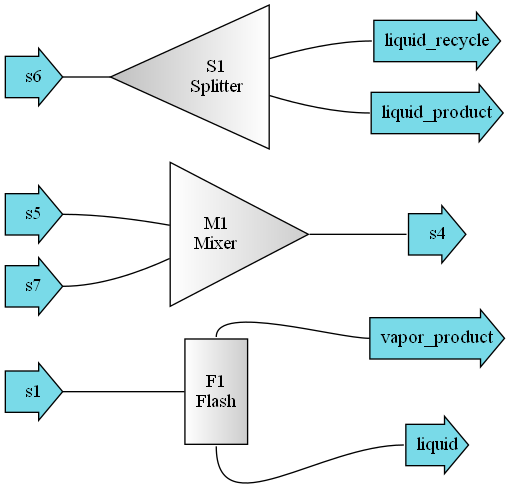

In [23]:
bst.main_flowsheet.diagram()

Connect streams and make a recycle loop using [-pipe- notation](./-pipe-_notation.ipynb):

In [24]:
feed = bst.Stream('feed', Methanol=100, Water=450)

# Broken down -pipe- notation
[S1-0, feed]-M1     # M1.ins[:] = [S1.outs[0], feed]
M1-F1               # F1.ins[:] = M1.outs
F1-1-S1             # S1.ins[:] = [F1.outs[1]]

# All together
[S1-0, feed]-M1-F1-1-S1;

Now lets check the diagram again:

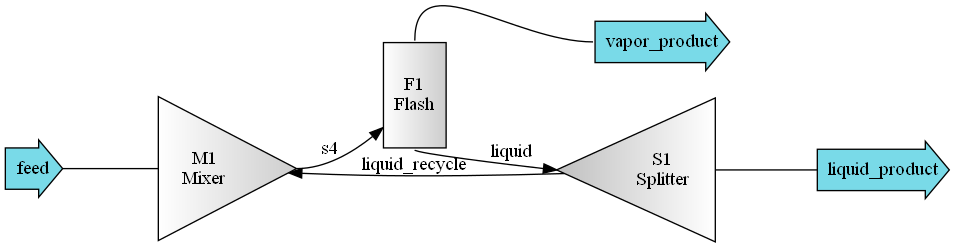

In [25]:
bst.main_flowsheet.diagram(format='png')

[System](../System.txt) objects take care of solving recycle loops and simulating all unit operations.
Although there are many ways of [creating a system](./Creating_a_system.ipynb), the most recommended way is to use the flowsheet:

In [26]:
flowsheet_sys = bst.main_flowsheet.create_system('flowsheet_sys')
flowsheet_sys.show()

System: flowsheet_sys
Highest convergence error among components in recycle
stream S1-0 after 0 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     450
                    Methanol  100
outs...
[0] vapor_product
    phase: 'g', T: 359.63 K, P: 101325 Pa
    flow (kmol/hr): Water     19
                    Methanol  16
[1] liquid_product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Although not recommened due to the likelyhood of human error, a [System](../System.txt) object may also be created by specifying an ID, a `recycle` stream and a `path` of units to run element by element:

In [27]:
sys = bst.System('sys', path=(M1, F1, S1), recycle=S1-0) # recycle=S1.outs[0]
sys.show()

System: sys
Highest convergence error among components in recycle
stream S1-0 after 0 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     450
                    Methanol  100
outs...
[0] vapor_product
    phase: 'g', T: 359.63 K, P: 101325 Pa
    flow (kmol/hr): Water     19
                    Methanol  16
[1] liquid_product
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Simulate the System object:

In [28]:
sys.simulate()
sys.show()

System: sys
Highest convergence error among components in recycle
stream S1-0 after 4 loops:
- flow rate   1.38e-01 kmol/hr (0.16%)
- temperature 4.43e-03 K (0.0012%)
ins...
[0] feed
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     450
                    Methanol  100
outs...
[0] vapor_product
    phase: 'g', T: 366.37 K, P: 101325 Pa
    flow (kmol/hr): Water     275
                    Methanol  92.1
[1] liquid_product
    phase: 'l', T: 366.37 K, P: 101325 Pa
    flow (kmol/hr): Water     175
                    Methanol  7.9


C:\Users\yrc2\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: F1> Vertical vessel weight (2965 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
C:\Users\yrc2\Code\biosteam\biosteam\units\design_tools\pressure_vessel.py:82: CostWarning: <Flash: F1> Vertical vessel length (10.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)


Note how the recycle stream converged and all unit operations (including the flash vessel) were simulated:

In [29]:
F1.results()

Flash                                                 Units            F1
Low pressure steam  Duty                              kJ/hr      1.82e+07
                    Flow                            kmol/hr           470
                    Cost                             USD/hr            94
Design              Vessel type                                  Vertical
                    Length                               ft          10.5
                    Diameter                             ft           5.5
                    Weight                               lb      2.97e+03
                    Wall thickness                       in         0.312
                    Vessel material                          Carbon steel
Purchase cost       Heat_exchanger - Double pipe        USD      5.12e+03
                    Heat_exchanger - Floating head      USD      2.87e+04
                    Vertical pressure vessel            USD      2.36e+04
                    Platform and ladders                USD      7.63e+03
Total purchase cost                                     USD       6.5e+04
Utility cost                                         USD/hr            94

You can retrieve summarized power and heat utilities from the system as well:

In [30]:
sys.power_utility.show()

PowerUtility:
 consumption: 0 kW
 production: 0 kW
 rate: 0 kW
 cost: 0 USD/hr


In [31]:
for i in sys.heat_utilities: i.show()

HeatUtility: low_pressure_steam
 duty: 1.82e+07 kJ/hr
 flow: 470 kmol/hr
 cost: 94 USD/hr


Once your system has been simulated, you can save a system report to view all results in an excel spreadsheet:

In [32]:
# Try this on your computer and open excel
# sys.save_report('Example.xlsx') 

Note that the cash flow analysis did not appear in the report because it requires a [TEA](../TEA.txt) object with all the necessary parameters (e.g., depreciation schedule, plant lifetime, construction schedule) to perform the analysis. A [TEA](../TEA.txt) object may also solve for economic indicators such as internal rate of return, minimum product selling price (MPSP), and maximum feedstock purchase price (MFPP). [Techno-economic analysis](./Techno-economic_analysis.ipynb) is discussed in detail later in the tutorial due to the extensive nature of the cash flow analysis.